In [1]:
import numpy as np
from numpy.random import randint,uniform,choice
import matplotlib.pyplot as plt
import datetime
import time

from numba import jit,njit,vectorize

In [ ]:
@vectorize
def setval(l,m):
    return np.int64(m)

@vectorize
def randdate(l):
    return randint(np.int64(l))

@njit
def rnd(x, decimals, out):
    return np.round_(x, decimals, out)

@njit
def log_output(lq_tests_conducted, hq_tests_conducted, tests_conducted, results_declared, locations_moved):
    
    print("# LQ Tests Done in total  : "+str(lq_tests_conducted))
    print("# HQ Tests Done in total  : "+str(hq_tests_conducted))
    print("# ALL Tests Done in total : "+str(tests_conducted))
    print("# Results Given in total  : "+str(results_declared))
    print("# Locations Moved in total: "+str(locations_moved))

@njit
def TLR(rate, Tpars, T, home_loc_state, quarantine_confined, test_frac):
    
    pop = np.copy(quenched_pop)
    n_per_location = np.copy(quenched_n_per_location)
    link_weight = np.copy(quenched_link_weight)
    n = np.copy(n0)
    
    is_confined = np.zeros(n_pop,np.bool_)               # Boolean array, is confined? (Initial values, all "no".)
    being_tested= np.zeros(n_pop,np.bool_)               # Boolean array, is being tested?
    loc_confined= np.zeros(n_loc,np.bool_)               # Boolean array, is the location confined? <---NEW

    test = Tpars
    test_result = np.zeros(n_pop,dtype=np.int64)                # Array to hold results of test (+1 positive, -1 negative)

    loc_confined_time = setval(np.zeros(n_loc), -1000)
    next_test_date = setval(np.zeros(n_pop), 7)                # Don't conduct a test before this date per person. (Initially all day 0)    
    result_declared_date = setval(np.zeros(n_pop),-1000)       # Declare the result of last test on this day (initiall -1000)    
    
    
    tests_conducted    = 0
    hq_tests_conducted = 0
    lq_tests_conducted = 0
    results_declared   = 0
    locations_moved    = 0
    
    t = 0.0
    
    v = np.array([[-1, 0, 0, 0, 0, 0],              # Array to denote change per state per event
                  [ 1,-1,-1, 0, 0, 0],              # The row indexes the state variables, and the
                  [ 0, 1, 0,-1,-1, 0],              # column indexes the events. The number represents
                  [ 0, 0, 1, 1, 0, 1],
                  [ 0, 0, 0, 0, 1,-1]],np.float64)  # the change in that particular state, given an event.

    
    transitions = np.zeros((n_states,n_states),np.int64)
    r = np.zeros(n_events)                          # Empty array to store rates per event
    K = np.zeros(n_events,np.float64)               # Empty array to store number of events that occur in dt (Poisson distributed)
    
    alpha = 1 - Cpars[5]   # Effective reduction in transmissivity of infected individuals (BOTH A and I)
    
    
#     #### TESTS #################################
    
    tests_available_daily =np.int64(test_frac/100 * n_pop)
    tests_available_now   =np.int64(test_frac/100 * n_pop)  # test_frac% of population number of tests available
    
    lq_tests_daily      =np.int64(test[0][3] * tests_available_daily)
    lq_tests_available  =np.int64(test[0][3] * tests_available_daily)
    
    hq_tests_daily      =np.int64(test[1][3] * tests_available_daily)
    hq_tests_available  =np.int64(test[1][3] * tests_available_daily)
    
    if(lq_tests_daily + hq_tests_daily > tests_available_daily):
        print("More LQ + HQ tests available than total! Are you sure your test fractions for each test type are correct?")
    
    lq_sensitivity = test[0][0]
    lq_specificity = test[0][1]
    lq_result_delay= test[0][2]
    
    hq_sensitivity = test[1][0]
    hq_specificity = test[1][1]
    hq_result_delay= test[1][2]
    
#     ############################################
        
    output = np.zeros((np.int64(T+1),9),dtype=np.int64)
    
    output[0] = np.array([t,n[0],n[1],n[2],n[3],n[4], hq_tests_conducted, lq_tests_conducted, tests_available_now])
    
    day = np.int64(0)
    
    op_counter = np.int64(0)
    
    dot_data = np.zeros((np.int64(4*T/10),n_pop),dtype=np.int64)
    
    
    while(t<T):
       
        for i in range(0, n_loc):                 # Loop over locations
            
            indices = np.where(pop[:,3]==i)[0]    # Index in pop of individuals in this location
            N = len(indices)
            
            if(N==0):
                continue                           # If no one's in this location, skip this loop
            
            V = N - alpha*n_per_location[i][4]                                  # Assume one-to-one contact 
            
            conf_by_state_in_loc = np.zeros(n_states,np.int64) # Number of confined individuals by state in location
            
            if(quarantine_confined == True):       # If you want to reduce infectivity of confined individuals, find out how many there are
                conf_state = is_confined[indices]
                
                for m in range(0,N):               # Change the new "confined per state location" numbers
                    if(conf_state[m] == True):     # If the person is confined
                        conf_by_state_in_loc[pop[indices[m]][0]] += 1
                
            # This part can be done more efficiently using a matrix, but that's for later
            
            r[0] = rate[0][1] * n_per_location[i][0] * 1/V * (Cpars[1]*(n_per_location[i][1] - conf_by_state_in_loc[1]*alpha)  + Cpars[2]*(n_per_location[i][2]- conf_by_state_in_loc[2]*alpha) + Cpars[4]*n_per_location[i][4])
            r[1] = rate[1][2] * n_per_location[i][1]
            r[2] = rate[1][3] * n_per_location[i][1]
            r[3] = rate[2][3] * n_per_location[i][2]
            r[4] = rate[2][4] * n_per_location[i][2]
            r[5] = rate[4][3] * n_per_location[i][4]
            
            flag = False
            counter = 0
            
            while(flag == False):
                for j in range(0,n_events):
                    K[j] = np.random.poisson(r[j]*dt)
                
                transitions[0][1] = K[0]
                transitions[1][2] = K[1]
                transitions[1][3] = K[2]
                transitions[2][3] = K[3]
                transitions[2][4] = K[4]
                transitions[4][3] = K[5]

                n_removed = np.sum(transitions,axis=1) # Number of people ideally needing to be removed

                for j in range(0,n_states):
                    if( n_per_location[i][j] < n_removed[j] and n_removed[j] != 0):
                        y=np.empty_like(transitions[j,:])
                        transitions[j,:] = rnd(transitions[j,:]/n_removed[j] * n_per_location[i][j],0,y)

                K[0] = transitions[0][1]
                K[1] = transitions[1][2]
                K[2] = transitions[1][3]
                K[3] = transitions[2][3]
                K[4] = transitions[2][4]
                K[5] = transitions[4][3]

                n_per_location[i] +=  rnd(np.dot(v,K),0,np.empty_like(n_per_location[i]))            # Change number per location by Sum_j v_ij K_j 
                
                
                if(np.any(n_per_location[i]<0)):
                    print("Negative populations! Shouldn't be happening!")
                    print(transitions)
                    print(n_per_location[i])
                    print("Rolling back")
                    n_per_location[i] -=  rnd(np.dot(v,K),0,np.empty_like(n_per_location[i]))
                    print(n_per_location[i])
                    print("Trying again...")
                    counter += 1
                    
                    if counter == 9:                        # Don't let more than 10 retries occur
                        print("Fatal error: 10 retries didn't get rid of negative populations")
                        break
                else:
                    flag = True
            

            if(np.all(transitions==0)):               # Skip this loop if no transitions need to occur
                continue
            
            
            done = np.zeros(len(indices),np.bool_)        # Array to make sure same individual isn't shifted more than once 
            for j in range(0,n_states):
                for k in range(0,n_states):
                    l=0
                    for m in range(0,len(indices)): # Go over everyone in this location
                        if(l==transitions[j][k]):
                            break

                        if(pop[indices[m]][0] == j and not done[m]):  # If they are j
                            pop[indices[m]][0] = k    # change them to k
                            n[j] -= 1                 # Decrement number of j
                            n[k] += 1                 # Increment number of k
                            
                            if(k==3): # If they recover,
                                is_confined[indices[m]] = False # Remove any confinement, and
                                
                                # Shift them home
                                if( pop[indices[m]][3] != pop[indices[m]][1] or pop[indices[m]][3] != pop[indices[m]][2] ):
                                    
                                    n_per_location[pop[indices[m]][3]][k] -= 1
                                    pop[indices[m]][3] = pop[indices[m]][1]   # Send them home
                                    n_per_location[pop[indices[m]][3]][k] += 1
                                    
                            elif(k==4):                 # If they are hospitalised
                                h = randint(n_hospitals)
                                n_per_location[pop[indices[m]][3]][k] -= 1 # Decrement the number of hospitalised in current (HOME or WORK) location
                                
                                pop[indices[m]][3] = h # Send them to a random hospital
                                n_per_location[pop[indices[m]][3]][k] += 1 # Increment the number of hospitalised (4) in current (hospital) location
                                
                                is_confined[indices[m]] =  False # Remove confinement   
                            
                            done[m] = True            # Don't repeat this index
                            l += 1

        for i in range(0,n_pop): 
            
            #### TESTING ###########################################
            
            p = test_frac/100 * dt     # Probability of testing someone (random) in time dt
            
            if (day >= next_test_date[i] and not being_tested[i] 
                and uniform(0.0,1.0) < p and tests_available_now>0): # Check if person i should be tested
                
                # If so, perform a test.
                being_tested[i]   = True            
                tests_conducted += 1
                
                tests_available_now -= 1                     # Reduce number of tests available
                
                test_type = choice(np.array([0,1]))                    # Choose HQ or LQ test randomly                
               
                if(test_type == 0 and lq_tests_available<=0):   # If a LQ test is chosen but no LQ tests available
                    test_type = 1                               # Do a HQ test
                elif(test_type == 1 and hq_tests_available<=0): # Or if a HQ test is chosen but no HQ tests available
                    test_type = 0                               # Do a LQ test
                    
                    
                if(test_type == 0 and lq_tests_available>0):
                    
                    # Do low quality test    
                    lq_tests_conducted += 1
                    lq_tests_available -= 1  # Reduce number of LQ tests
                    
                    next_test_date[i]       = day + days_bw_lq_tests   # Set date for next test
                    result_declared_date[i] = day + lq_result_delay # No. of days (from today) to wait to get the result
                
                    if ((pop[i][0]==1 or pop[i][0]==2) 
                        and uniform(0.0,1.0)<lq_sensitivity) or ((pop[i][0]==0 or pop[i][0]==3) 
                                                                    and uniform(0.0,1.0)>lq_specificity): # If the person is infected and the test works 
                        test_result[i] = 1
                    else:
                        test_result[i] = -1
                    
                elif(test_type == 1 and hq_tests_available>0):
                    
                    # Do high quality test
                    hq_tests_conducted += 1
                    hq_tests_available -= 1  # Reduce number of HQ tests
                    
                    next_test_date[i]       = day + days_bw_hq_tests  # Set date for next test
                    result_declared_date[i] = day + hq_result_delay   # No of days (from today) to wait to get the result
                    
                    if ((pop[i][0]==1 or pop[i][0]==2) 
                        and uniform(0.0,1.0)<hq_sensitivity) or ((pop[i][0]==0 or pop[i][0]==3) 
                                                                    and uniform(0.0,1.0)>hq_specificity): # If the person is infected and the test works 
                        test_result[i] = 1
                    else:
                        test_result[i] = -1
                        
            #### DONE TESTING ######################################
            
            #### DECLARING RESULTS #################################
            
            if (day == result_declared_date[i] and being_tested[i]):  # Should we declare the person's results?
                
                # If so, set them to not being_tested
                being_tested[i] = False
                results_declared += 1
                
                # Declare results
                
                if (test_result[i] == 1 and pop[i][0]!=4):             # If they tested positive AND are now not in a hospital
                    
                    is_confined[i] = True                              # Confine them 
                    
                    n_per_location[pop[i][3]][pop[i][0]] -= 1          # Decrement number of person's state in current (NET or HOME) location of person
                    
                    if(pop[i][3] == pop[i][2]):                        # If they're at work
                        pop[i][3] = pop[i][1]                          # send them home
                    
                    n_per_location[pop[i][3]][pop[i][0]] += 1          # Increment number of person's state in current location (now HOME) of person

                    loc_confined[pop[i][1]] = home_loc_state           # Confine their home location for total_loc_confined_time (?) days
                    loc_confined_time[pop[i][1]] = t                   # Time when location is confined

                elif(test_result[i] == -1 or pop[i][0] == 4):          # If the test result is negative OR if the person's moved to the hospital
                    
                    is_confined[i] = False                             # If result is negative, let them move about
        
                test_result[i] = 0                                     # Set test_result back to 0      
            
            #### DONE DECLARING RESULTS ############################
            
            #### MOVE PEOPLE AROUND ################################  
        
            if (not is_confined[i] and not loc_confined[pop[i][3]]):  # If they aren't confined AND their CURRENT location isn't confined

                locs_changed = np.random.poisson( link_weight[i]*dt ) % 2 # Net number of locations changed in time dt. 
                                                                          # (An even number means you get back to where you were)
                
                locations_moved += locs_changed
                
                if(locs_changed==1):
                    home_loc = pop[i][1]
                    net_loc  = pop[i][2]

                    if(pop[i][3]==home_loc):                       # If the person is at home
                        pop[i][3] = net_loc                        # move them to their network location
                        
                        n_per_location[home_loc][pop[i][0]] -= 1   # Reduce number of individual's state at home
                        n_per_location[ net_loc][pop[i][0]] += 1   # Increase number of individual's state at work
                    
                    elif(pop[i][3]==net_loc):
                        pop[i][3] = home_loc                       # otherwise move them home
                        
                        n_per_location[ net_loc][pop[i][0]] -= 1   # Reduce number of individual's state at work
                        n_per_location[home_loc][pop[i][0]] += 1   # Increase number of individual's state at home

                   # If they're in any other location, keep them there.
    
        # Lock or unlock homes
        
        for i in range(0,n_loc):
            if(loc_confined[i]==True and t - loc_confined_time[i] > total_loc_confined_time):  # If the current time - the time it was last confined is > 10 days
                loc_confined_time[i] = -1000                        
                loc_confined[i] = False                             # Remove confinement restriction
        
        
        if(t>day):
            day += 1
            output[day] = np.array([day,n[0],n[1],n[2],n[3],n[4], hq_tests_conducted, lq_tests_conducted, tests_available_now])
            tests_available_now = tests_available_daily
            lq_tests_available  = lq_tests_daily
            hq_tests_available  = hq_tests_daily
#             print(day)

            if(day%10==0):
                dot_data[op_counter:op_counter+4] = np.copy(np.transpose(pop))
                op_counter+=4
        
        t += dt
        # while loop ends
    
    # Counting recovered Healthcare Workers    
    hcw_recovered = 0
    for i in range(0, n_pop):  
        if(pop[i][2]<n_hospitals and pop[i][0] == 3): # If a healthcare worker is recovered
            hcw_recovered += 1
    
    return dot_data, output, test, np.array([home_loc_state,quarantine_confined,test_frac, lq_tests_conducted, hq_tests_conducted, tests_conducted, results_declared, locations_moved, hcw_recovered])

In [ ]:

def write_to_file(output, test, details, rate_to_print,eval_time):
#     ### WRITE OUTPUT TO FILE #####################
    
    date = datetime.datetime.now()
    dateString = date.strftime("%y%m%d%H%M%S%f")
    
    fileName = "../data/RandomTesting/Random_Testing_"+str(round(details[2],2))+"_RAT_"+str(round(test[0][0],2))+"_"+str(round(test[0][3],2))+"_PCR_"+str(round(test[1][0],2))+"_"+str(round(test[1][3],2))+"_"+dateString+".txt"
    
    def int_to_bool(bstate):
        if(bstate == 0):
            return False
        elif(bstate == 1):
            return True
    
    with open(fileName, "a") as file:
        file.write("###### TEST LOG ####################\n")
        file.write("# Time taken               : "+str(round(eval_time,2))+"s \n")
        
        file.write("# Test Parameters: \n")
        file.write("# "+str(test[0][0])+" "+str(test[0][1])+" "+str(test[0][2])+" "+str(test[0][3])+"\n")
        file.write("# "+str(test[1][0])+" "+str(test[1][1])+" "+str(test[1][2])+" "+str(test[1][3])+"\n")
        file.write("# Homes Quarantined?       : "+ str(int_to_bool(details[0]))+"\n")
        file.write("# Confined less Infective? : "+ str(int_to_bool(details[1]))+"\n")
        file.write("# Fraction Tested Daily    : "+ str(details[2])+"\n")
        
        file.write("# LQ Tests Done in total   : "+str(details[3])+"\n")
        file.write("# HQ Tests Done in total   : "+str(details[4])+"\n")
        file.write("# ALL Tests Done in total  : "+str(details[5])+"\n")
        file.write("# Results Given in total   : "+str(details[6])+"\n")
        file.write("# Locations Moved in total : "+str(details[7])+"\n")
        file.write("# Total recovered HCW      : "+str(details[8])+"\n")
        
        file.write("# Rate Array: \n")
        file.write("# "+str(rate_to_print[0])+"\n")
        file.write("# "+str(rate_to_print[1])+"\n")
        file.write("# "+str(rate_to_print[2])+"\n")
        file.write("# "+str(rate_to_print[3])+"\n")
        file.write("# "+str(rate_to_print[4])+"\n")
        file.write("###### END LOG #####################\n")
        file.write("#\n")
        
        np.savetxt(file, output, delimiter=" ",fmt="%i")

In [2]:
# IMPORT POPULATION #######################

quenched_pop            = np.genfromtxt('./quenched_pop.txt', delimiter=' ',dtype=int,comments="#")
quenched_n_per_location = np.genfromtxt('./quenched_n_per_location.txt', delimiter=' ',dtype=int,comments="#")
quenched_link_weight    = np.genfromtxt('./quenched_linkweight.txt', delimiter=' ',dtype=int,comments="#")

###########################################

Tpars  = np.array([[0.74, 0.98, 0, 0],          # Low quality: sensitivity, specificity, result delay, Fraction of tests
                   [1.0, 1, 0, 1]])         # High quality: sentitivity, specificity, result delay, Fraction of tests

tf=120

In [ ]:
%%time

from params import *

rate = np.copy(rate_array)

# dotd1,op1,test,details = TLR(rate, Tpars, tf, True, True, 0)
# writing(dotd1,0)
             
dotd5,op5,test,details = TLR(rate, Tpars, tf, True, True, 5)
writing(dotd5,5)

In [ ]:
# writing(dotd1,0)
writing(dotd5,5)

In [ ]:
ender = np.empty(n_loc+1,dtype=object)
for i in range(0,n_loc):
    if(0<=i<n_hospitals):
        ender[i] = str(i)+" [color=\"#aa0044\"];"
    elif(n_hospitals<=i<n_overlap-1):
        ender[i] = str(i)+" [color=\"#000000e6\"];"
    elif(n_overlap-1<=i<n_loc):
        ender[i] = str(i)+" [color=\"#b3b3b3\"];"
ender[n_loc]="}"

In [ ]:
print(ender)

In [ ]:
def writing(dd,trate):
    #clrs = np.array(["\"#005500\"","\"#808000\"","\"#800000\"","\"#6c5353\"","\"#216778\""])
    clrs = np.array(["\"#ffcb001a\"","\"#a0892c\"","\"#800000\"","\"#5fd35f59\"","\"#5555ff\""])
    cc = 0

    something = np.empty((n_pop,4),dtype=object)
    cs =["[color="]*n_pop
    cend = ["];"]*n_pop
    mid = ["--"]*n_pop

    # ender = np.empty((n_loc,2),dtype=object)

    for i in range(0,int(tf/10)):
        with open("./For Network Visualisation/"+str(trate)+"/random_network_test_rate_"+str(trate)+"_day_"+str(i*10)+".dot",'ab') as f:
            np.savetxt(f,["graph location_network {\ngraph [overlap=prism1000 outputorder=edgesfirst];\n node [shape=point];\n"],fmt="%s")
            something[:,0] = dd[cc:cc+4][1]
            something[:,1] = mid
            something[:,2] = dd[cc:cc+4][2]
            hexcol = clrs[dd[cc:cc+4][0]]

            something[:,3] = np.char.add(np.char.add(cs,hexcol),cend)

            np.savetxt(f,something,delimiter=" ",fmt="%s")
            np.savetxt(f,ender,delimiter=" ",fmt="%s")
        cc = cc+4


In [ ]:
print(ender)

In [ ]:
np.char.add(clrs[dd[0:4][0]],clrs[dd[0:4][0]])

In [ ]:
str(dd[8:10][1])

In [ ]:
print(ender)

In [ ]:
num_rec = []

for i in range(0,10):
    dd,op,test,details = TLR(rate, Tpars, tf, True, True, 0)
    num_rec.append(op[:,4])


In [ ]:
for i in range(0,10):
    plt.plot(np.linspace(0,120,121),num_rec[i],'--',color='mediumvioletred',alpha=0.6)

plt.plot(np.linspace(0,120,121),np.average(num_rec,axis=0),color='firebrick')
plt.xlabel("Time (Days)")
plt.ylabel("Number of individuals")

In [85]:
np.average(num_rec,axis=0)[-1]

NameError: name 'num_rec' is not defined

In [54]:
n_p = np.sum(quenched_n_per_location,axis=1)[250:2750]

In [118]:
print(np.count_nonzero(np.where(n_p==0)))


41


45.8

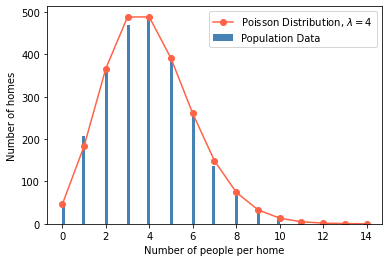

In [125]:

plt.hist(n_p,bins=100,label="Population Data",color='steelblue')
l=4
k_array = np.arange(0,15,1)
pdis = np.zeros(len(k_array))

for k in k_array:
    
    pdis[k] = 2500*l**k * np.exp(-l)/np.math.factorial(k)

    
plt.plot(k_array,pdis,'-o',label="Poisson Distribution, $\lambda=4$",color='tomato')
plt.xlabel("Number of people per home")
plt.ylabel("Number of homes")
plt.legend()

plt.savefig("./poisson_distribution_of_home_sizes.png",dpi=100,facecolor='w')


In [99]:
hh,bb=np.histogram(n_p)
print(hh)
print(bb)

[249 360 470 886 260 136 113  19   4   3]
[ 0.   1.3  2.6  3.9  5.2  6.5  7.8  9.1 10.4 11.7 13. ]


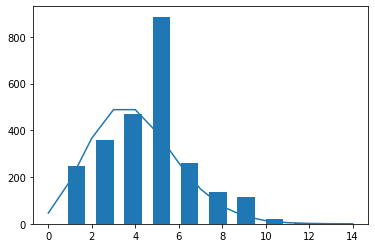

In [100]:
plt.bar(bb[1:],hh)
plt.plot(k_array,pdis)

(array([0.06307692, 0.        , 0.        , 0.32      , 0.        ,
        0.        , 0.        , 0.55384615, 0.        , 0.        ,
        0.        , 0.72307692, 0.        , 0.        , 0.        ,
        0.75230769, 0.        , 0.        , 0.        , 0.61076923,
        0.        , 0.        , 0.        , 0.4       , 0.        ,
        0.        , 0.20923077, 0.        , 0.        , 0.        ,
        0.12153846, 0.        , 0.        , 0.        , 0.05230769,
        0.        , 0.        , 0.        , 0.02923077, 0.        ,
        0.        , 0.        , 0.00615385, 0.        , 0.        ,
        0.        , 0.00307692, 0.        , 0.        , 0.00153846]),
 array([ 0.  ,  0.26,  0.52,  0.78,  1.04,  1.3 ,  1.56,  1.82,  2.08,
         2.34,  2.6 ,  2.86,  3.12,  3.38,  3.64,  3.9 ,  4.16,  4.42,
         4.68,  4.94,  5.2 ,  5.46,  5.72,  5.98,  6.24,  6.5 ,  6.76,
         7.02,  7.28,  7.54,  7.8 ,  8.06,  8.32,  8.58,  8.84,  9.1 ,
         9.36,  9.62,  9.88, 10.14

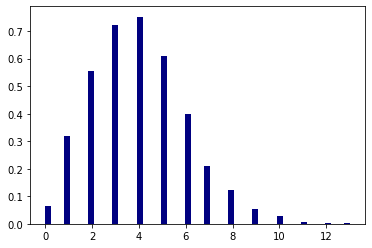

In [102]:
plt.hist(n_p,bins=50,label="Population Data",color='navy',density=True)

In [108]:
0.2*2500

500.0